In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import peakutils
from skimage.measure import EllipseModel
from scipy.interpolate import interp1d
from extract_center import CenterExtracter
from matplotlib.patches import Ellipse
plt.rcdefaults()

In [10]:
DATA_DIR = '../data/images1/'
RESULT_DIR = '../data/results/'

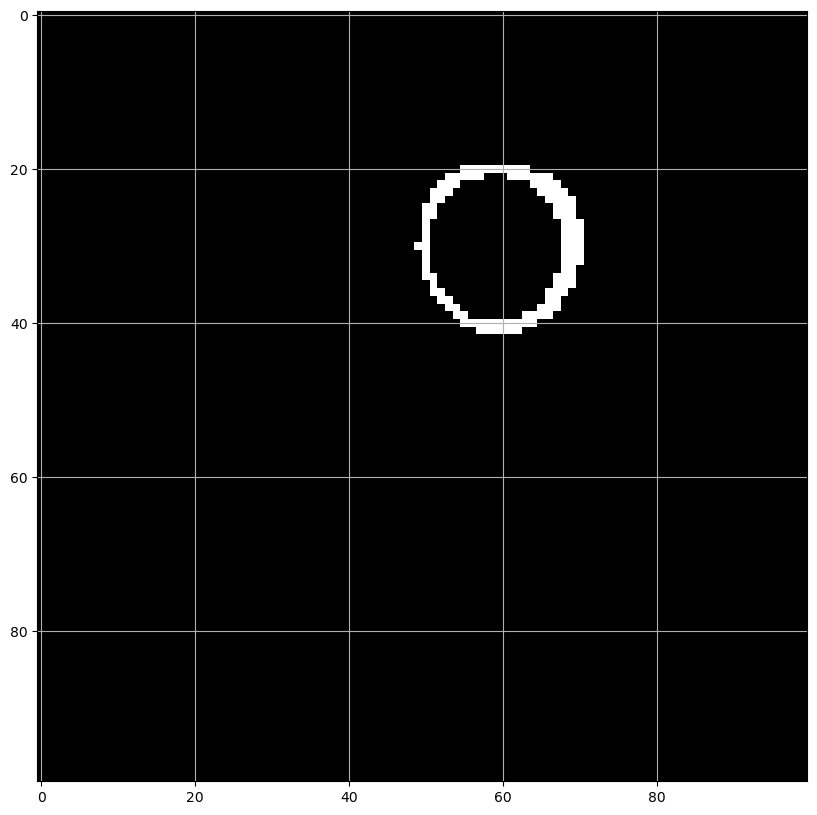

In [16]:
c = CenterExtracter()
img = c._read_image(os.path.join(DATA_DIR, "30.jpg"))
img = c._subtract_image(img)
img = c._threshold(image=img)
img = c._crop(img, 110, 50, 100, 100)
c._show_image(img)

### Edge Detection

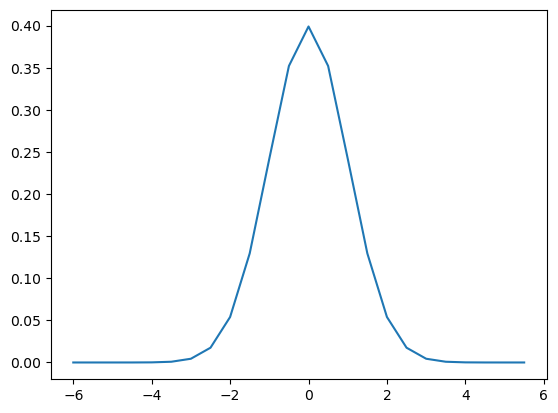

In [7]:
x = np.arange(-6, 6, 0.5)
gaussian_kernel = np.exp(-x ** 2 / 2.)/ np.sqrt(2 * np.pi)
line = plt.plot(x, gaussian_kernel)

In [12]:
def plot_row_intensity(row):
    row_values = img[row, :]
    inter = interp1d(range(len(row_values)), row_values, kind='cubic', bounds_error=False, fill_value=0)
    x = np.arange(0, len(row_values), 0.1)
    y = inter(x)
    kernel = [-3,0,3]
    plt.figure(figsize=(8,5))
    gaussian = np.convolve(y, gaussian_kernel, mode='same')
    plt.plot(gaussian, 'g', label="Gaussian")
    convoled = np.convolve(gaussian, kernel, mode='same')
    plt.plot(convoled, 'r', label="Differentiated")
    plt.plot(y, 'b', label = "Original")
    plt.legend()
    return gaussian, convoled, y

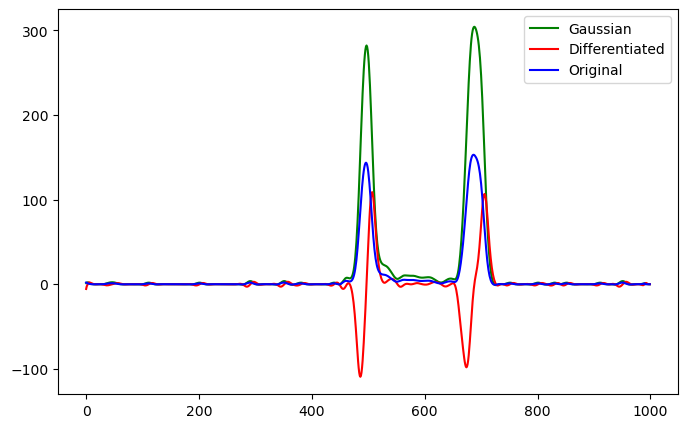

In [13]:
gaussian, convolved, y = plot_row_intensity(40)

In [14]:
peakutils.indexes(gaussian)/10+[c.X, c.Y]

array([749.7, 418.8])

In [15]:
peakutils.indexes(-convolved, thres=0.7)/10 + [c.X, c.Y]

array([748.6, 417.4])

In [16]:
peakutils.indexes(y)/10+[c.X, c.Y]

array([749.6, 418.7])

In [21]:
def get_edges(array, method="all", x=None, y=None, thres=0.6, min_array_value=110):
    #Ignoring the noise
    if max(array)<min_array_value:
        return None
    
    #Interpolating the array
    inter = interp1d(range(len(array)), array, kind='cubic', bounds_error=False, fill_value=0)
    X = np.arange(0, len(array), 0.1)
    Y = inter(X)

    #Convolving with the gaussian kernel and Differential Kernel
    kernel = [-3,0, 3]
    gaussian = np.convolve(Y, gaussian_kernel, mode='same')
    differentiated = np.convolve(gaussian, kernel, mode='same')

    #Detecting the peaks
    gaussian_points = peakutils.indexes(gaussian, thres=thres)/10
    diff_points = peakutils.indexes(-differentiated, thres=thres)/10
    y_points = peakutils.indexes(Y, thres=thres)/10

    #Compenseting for more than two peaks
    peaks =[gaussian_points, diff_points, y_points]
    modified_peaks = []
    for peak in peaks:
        if len(peak)>2:
            peak = np.array([peak[0], peak[-1]])
        else:
            peak = peak
        modified_peaks.append(peak)
    gaussian_points, diff_points, y_points = modified_peaks
    #Using the method specified
    if method == "all":
        point = (gaussian_points+diff_points+y_points)/3
    elif method == "gaussian":
        point = gaussian_points
    elif method == "diff":
        point = diff_points
    elif method == "y":
        point = y_points
    elif kernel.lower() == "gaussian_y":
        point = (gaussian_points + y_points) / 2

    #Getting the x and y coordinates
    if x is None:
        point1 = (round(point[0], 1), y)
        try:
            point2 = (round(point[1], 1), y)
        except IndexError:
            point2 = (round(point[0], 1), y)
    else:
        point1 = (x, round(point[0], 1))
        try:
            point2 = (x, round(point[1], 1))
        except IndexError:
            point2 = (x, round(point[0], 1))
    return point1, point2
    

In [22]:
array = img[30, :]
thres=0.6
inter = interp1d(range(len(array)), array, kind='cubic', bounds_error=False, fill_value=0)
X = np.arange(0, len(array), 0.1)
Y = inter(X)
kernel = [-1,0, 1]
gaussian = np.convolve(Y, gaussian_kernel, mode='same')
differentiated = np.convolve(gaussian, kernel, mode='same')
gaussian_points = peakutils.indexes(gaussian, thres=thres)/10
diff_points = peakutils.indexes(-differentiated, thres=thres)/10
if len(diff_points)>2:
    diff_points = peakutils.indexes(-differentiated, thres=0.8)/10
    diff_points = np.array([diff_points[0], diff_points[-1]])
y_points = peakutils.indexes(Y, thres=thres)/10

In [23]:
all_points_1 = []
all_points_2 = []
for i in range(img.shape[0]):
    points1 = get_edges(img[i, :], method="all", y=i, thres=0.6)
    if points1 is not None:
        all_points_1.append(points1)

for i in range(img.shape[1]):
    points2 = get_edges(img[:, i], method="all", x=i, thres=0.6)
    if points2 is not None:
        all_points_2.append(points2)

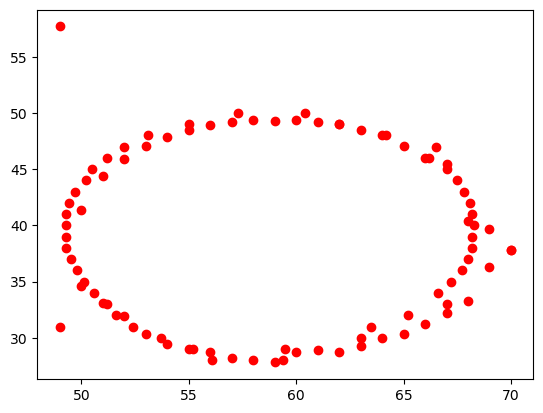

In [24]:
points = []
for i in range(len(all_points_1)):
    (xl, y), (xr, y) = all_points_1[i]
    points.append((xl, y))
    points.append((xr, y))

for i in range(len(all_points_2)):
    (x, yl), (x, yr) = all_points_2[i]
    points.append((x, yl))
    points.append((x, yr))

xs = np.array([p[0] for p in points])
ys = np.array([p[1] for p in points])

plt.plot(xs, ys, 'ro')

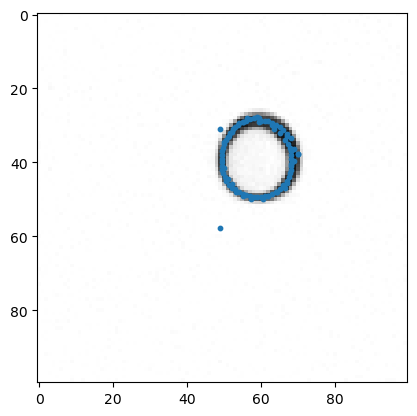

In [25]:
plt.imshow(-img, cmap='gray')
plt.scatter(xs, ys, s=10,)

In [26]:
def get_points(img, method="all", thres=0.6):
    all_points_1 = []
    all_points_2 = []
    for i in range(img.shape[0]):
        points1 = get_edges(img[i, :], method=method, y=i, thres=thres)
        if points1 is not None:
            all_points_1.append(points1)

    for i in range(img.shape[1]):
        points2 = get_edges(img[:, i], method=method, x=i, thres=thres)
        if points2 is not None:
            all_points_2.append(points2)
    
    points = []
    for i in range(len(all_points_1)):
        (xl, y), (xr, y) = all_points_1[i]
        points.append((xl, y))
        points.append((xr, y))

    for i in range(len(all_points_2)):
        (x, yl), (x, yr) = all_points_2[i]
        points.append((x, yl))
        points.append((x, yr))

    xs = np.array([p[0] for p in points])
    ys = np.array([p[1] for p in points])

    plt.imshow(-img, cmap='gray')
    plt.scatter(xs, ys,s=5, c='r')
    return xs, ys

def drop_points(xs, ys, drop_points=2):
    x_sort_index = np.argsort(xs)
    values = x_sort_index[drop_points:-drop_points]
    xs = xs[values]
    ys = ys[values]

    y_sort_index = np.argsort(ys)
    values = y_sort_index[drop_points:-drop_points]
    xs = xs[values]
    ys = ys[values]
    return xs, ys

In [27]:
def fit_and_plot_ellipse(xs, ys):
    points = np.array([xs, ys]).T
    ell = EllipseModel()
    ell.estimate(points)
    xc, yc, a, b, theta = ell.params

    print("center = ",  (xc+c.X, yc+c.Y))
    print("angle of rotation = ",  theta)
    print("axes = ", (a,b))

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 5)
    axs[0].scatter(xs,ys)

    axs[1].scatter(xs, ys)
    axs[1].scatter(xc, yc, color='red', s=100)
    axs[0].set_title("All points")
    axs[1].set_xlim(xs.min()-2, xs.max()+2)
    axs[1].set_ylim(ys.min()-2, ys.max()+2)

    ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

    axs[1].add_patch(ell_patch)
    axs[1].set_title("Fitted Ellipse")
    plt.show()
    return (xc, yc), (a, b), theta

### Removing Outliers

In [28]:
def drop_points(xs, ys, drop_points=2):
    x_sort_index = np.argsort(xs)
    values = x_sort_index[drop_points:-drop_points]
    xs = xs[values]
    ys = ys[values]

    y_sort_index = np.argsort(ys)
    values = y_sort_index[drop_points:-drop_points]
    xs = xs[values]
    ys = ys[values]
    return xs, ys

center =  (868.8437270149977, 439.04496142252924)
angle of rotation =  1.541119176068591
axes =  (10.592700932904098, 9.617654096924108)


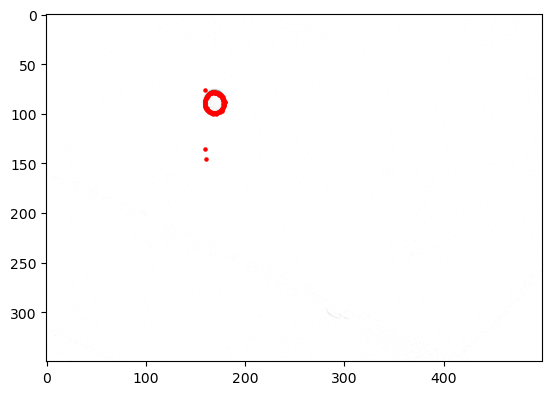

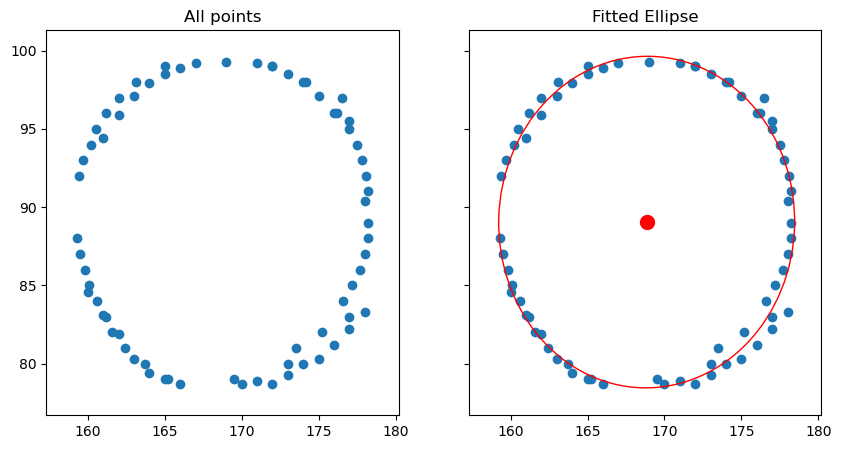

center =  (867.1871675691966, 450.09764755479955)
angle of rotation =  1.7202808832210923
axes =  (24.83298624017977, 8.682027048922759)


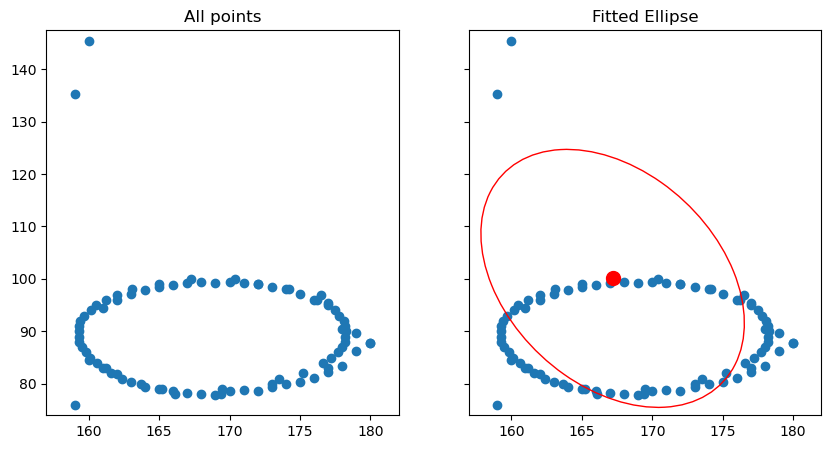

((167.18716756919662, 100.09764755479955),
 (24.83298624017977, 8.682027048922759),
 1.7202808832210923)

In [36]:
c = CenterExtracter()
img = c._read_image(os.path.join(DATA_DIR+"34.jpg"))
img = c._subtract_image(img)
img = c._crop(img, 0, 0, 500, 500)
# c._show_image_(img)
xs, ys = get_points(img, method="all", thres=0.6)

xs_m, ys_m = drop_points(xs, ys, 5)

(xc, yc), (a, b), theta = fit_and_plot_ellipse(xs_m, ys_m)
fit_and_plot_ellipse(xs, ys)

In [37]:
len(xs_m), len(xs)

(70, 90)

## Fitting Ellipse

#### All the Points

In [38]:
def fit_and_plot_ellipse(xs, ys):
    points = np.array([xs, ys]).T
    ell = EllipseModel()
    ell.estimate(points)
    xc, yc, a, b, theta = ell.params

    print("center = ",  (xc+c.X+110, yc+c.Y+50))
    print("angle of rotation = ",  theta)
    print("axes = ", (a,b))

    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_size_inches(10, 5)
    axs[0].scatter(xs,ys)

    axs[1].scatter(xs, ys)
    axs[1].scatter(xc, yc, color='red', s=100)
    axs[0].set_title("All points")
    axs[1].set_xlim(xs.min(), xs.max())
    axs[1].set_ylim(ys.min(), ys.max())

    ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

    axs[1].add_patch(ell_patch)
    axs[1].set_title("Fitted Ellipse")
    plt.show()

center =  (978.8437270149977, 489.04496142252924)
angle of rotation =  1.541119176068591
axes =  (10.592700932904098, 9.617654096924108)


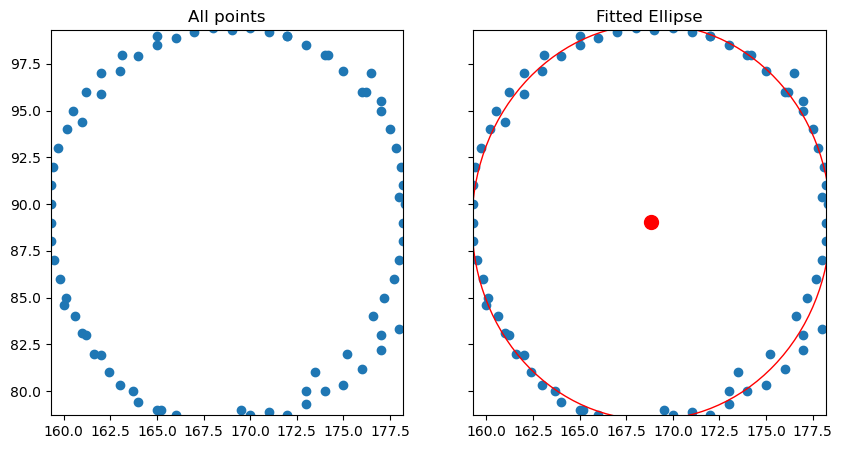

In [39]:
points = np.array([xs_m, ys_m]).T
ell = EllipseModel()
ell.estimate(points)
xc, yc, a, b, theta = ell.params

print("center = ",  (xc+c.X+110, yc+c.Y+50))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 5)
axs[0].scatter(xs,ys)

axs[1].scatter(xs, ys)
axs[1].scatter(xc, yc, color='red', s=100)
axs[0].set_title("All points")
axs[1].set_xlim(xs_m.min(), xs_m.max())
axs[1].set_ylim(ys_m.min(), ys_m.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
axs[1].set_title("Fitted Ellipse")
plt.show()
# fig.savefig("ellipse_fit.png")

#### Leaving the Outliers

In [213]:
values = xs.argsort()
values[2:-2]

array([24, 26, 28, 22, 30, 20, 32, 18, 51, 50, 16, 34, 36, 14, 52, 53, 12,
       38, 10, 40, 54, 55,  8, 57, 56, 42,  6, 59, 58, 44, 61, 60,  4, 63,
       62,  2, 65, 64, 46, 66, 67,  1,  0, 69, 68,  3,  5, 70, 71, 47, 72,
       73, 74, 75, 45, 77, 76,  7,  9, 79, 78, 43, 81, 80, 11, 82, 83, 39,
       41, 15, 13, 85, 84, 37, 17, 35, 19, 33, 86, 87, 21, 31, 29, 23, 25,
       27, 88, 89], dtype=int64)

In [215]:
xs_new = xs[values[2:-2]]
ys_new = ys[values[2:-2]]

center =  (868.8797251552724, 438.92799951989286)
angle of rotation =  -0.03158220898773167
axes =  (9.572597263507898, 10.798650794223427)


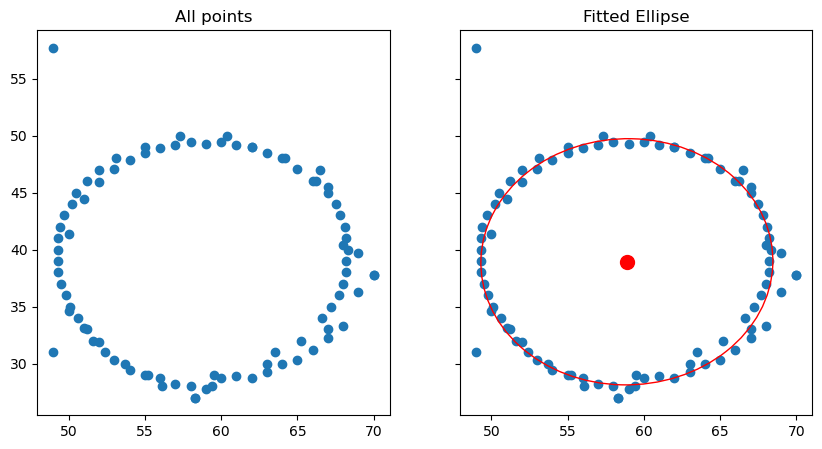

In [216]:
points = np.array([xs_new, ys_new]).T
ell = EllipseModel()
ell.estimate(points)
xc, yc, a, b, theta = ell.params

print("center = ",  (xc+c.X+110, yc+c.Y+50))
print("angle of rotation = ",  theta)
print("axes = ", (a,b))

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(10, 5)
axs[0].scatter(xs,ys)

axs[1].scatter(xs, ys)
axs[1].scatter(xc, yc, color='red', s=100)
axs[0].set_title("All points")
# axs[1].set_xlim(xs.min(), xs.max())
# axs[1].set_ylim(ys.min(), ys.max())

ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

axs[1].add_patch(ell_patch)
axs[1].set_title("Fitted Ellipse")
plt.show()
# fig.savefig("ellipse_fit.png")

### Final

In [1]:
from extract_center import CenterExtracter
c = CenterExtracter()
DATA_DIR = '../data/images1/'
RESULT_DIR = '../data/results/'

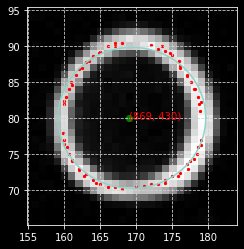

((869, 430), (10, 9), 1.52)

In [8]:
c.fit_ellipse(os.path.join(DATA_DIR+"30.jpg"), kernel="gaussian_y", drop_points=5, plot=True, min_array_value=80)

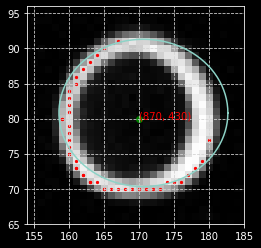

((870, 430), (12, 10), 0.81)

In [4]:
c.fit_ellipse(os.path.join(DATA_DIR+"30.jpg"), binary=True, plot=True)